In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping

In [2]:
# Parameters
stocks = 'TSLA'
start_date = '2014-01-01'
end_date = '2024-12-31'
input_days_list = [60, 30, 10, 5]  # Different input days for training

In [3]:
# Download stock data
df = yf.download(stocks, start=start_date, end=end_date)
df.reset_index(inplace=True)

# Data Preparation
features = df['Close'].values
features = features.astype('float32')

[*********************100%***********************]  1 of 1 completed


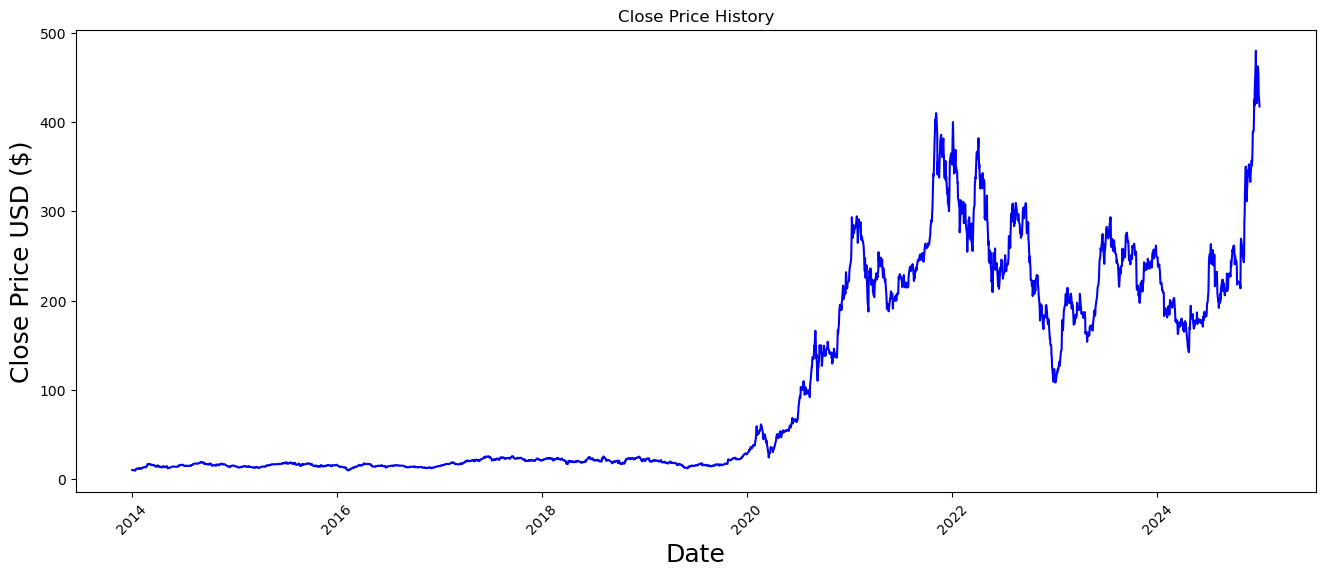

In [4]:
# Plotting the closing price
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Close'], color='blue')
plt.title('Close Price History')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.xticks(rotation=45)
plt.show()

In [5]:
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features.reshape(-1, 1))

# Prepare sequences
training_data_len = int(np.ceil(len(scaled_features) * 0.8))

In [6]:
# Create a function to train, predict, and visualize with various input days
def train_and_predict(input_days):
    # Create training data
    train_data = scaled_features[:training_data_len]
    x_train, y_train = [], []

    for i in range(input_days, len(train_data)):
        x_train.append(train_data[i-input_days:i])
        y_train.append(train_data[i])

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Reshape x_train for LSTM
    x_train = x_train.reshape(-1, input_days, 1)

    # Create testing data
    test_data = scaled_features[training_data_len - input_days:]
    x_test, y_test = [], []

    for i in range(input_days, len(test_data)):
        x_test.append(test_data[i-input_days:i])
        y_test.append(test_data[i])

    x_test = np.array(x_test)
    y_test = np.array(y_test)

    # Reshape x_test for LSTM
    x_test = x_test.reshape(-1, input_days, 1)

    # Initialize and compile the model
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(x_train, y_train, epochs=1000, batch_size=32, validation_data=(x_test, y_test), verbose=1, shuffle=False)

    # Make predictions
    train_predictions = model.predict(x_train)
    test_predictions = model.predict(x_test)

    # Inverse transform the predictions to get the actual prices
    train_predictions = scaler.inverse_transform(train_predictions)
    test_predictions = scaler.inverse_transform(test_predictions)

    # Visualization of Predictions
    train = df[:training_data_len]
    valid = df[training_data_len:].copy()
    valid['Predictions'] = test_predictions.flatten()

    plt.figure(figsize=(16, 6))
    plt.title(f'LSTM Model Predictions with {input_days} Days Input')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Date'], train['Close'], label='Train')
    plt.plot(valid['Date'], valid['Close'], label='Val', color='green')
    plt.plot(valid['Date'], valid['Predictions'], label='Predictions', color='orange')
    plt.legend(loc='lower right')
    plt.show()

    # Calculate performance metrics
    mse = mean_squared_error(valid['Close'], valid['Predictions'])
    mae = mean_absolute_error(valid['Close'], valid['Predictions'])
    rmse = np.sqrt(mse)
    r2 = r2_score(valid['Close'], valid['Predictions'])

    print(f"Performance metrics for input days {input_days}:")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("\n")

    # Plot train and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
    plt.title(f'Model Train vs Validation Loss with {input_days} Days Input')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

    # Predict the next day using the last input_days
    last_input_days = scaled_features[-input_days:]
    last_input_days = last_input_days.reshape((1, input_days, 1))

    predicted_price = model.predict(last_input_days)
    predicted_price = scaler.inverse_transform(predicted_price)

    # Display the next day's predicted price
    next_day_date = df['Date'].iloc[-1] + pd.Timedelta(days=1)
    predicted_df = pd.DataFrame(data=predicted_price, index=[next_day_date], columns=['Predicted Close'])

    print(f"Predicted stock price for {next_day_date.date()} (using last {input_days} days): ${predicted_price[0][0]:.2f}")

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(df['Date'], df['Close'], label='Historical Close Prices', color='blue')
    plt.axvline(x=next_day_date, color='orange', linestyle='--', label='Prediction Date')
    plt.scatter(next_day_date, predicted_price, color='red', label='Predicted Price', s=100)

    # Add titles and labels
    plt.title('Predicted Next Day Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Price in USD')
    plt.legend()
    plt.grid()
    plt.show()

Epoch 1/1000


c:\Users\ben\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.0011 - val_loss: 0.0106
Epoch 2/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 3/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 4/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0097 - val_loss: 0.0051
Epoch 5/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0116 - val_loss: 0.0044
Epoch 6/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0082 - val_loss: 0.0034
Epoch 7/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0067 - val_loss: 0.0019
Epoch 8/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 9/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 1.9776e-04 - val_loss: 0.0016
Epoch 10/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 2.2534e-04 - val_loss: 0.0015
Epoch 11/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 8.6244e-04 - val_loss: 0.0012
Epoch 12/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 6

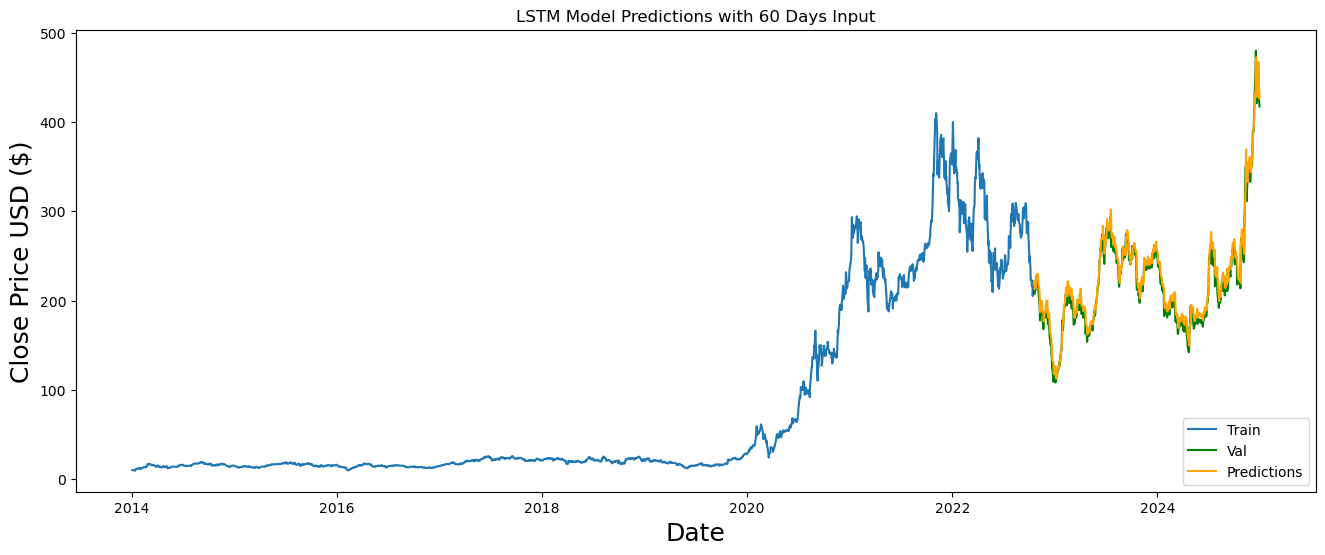

Performance metrics for input days 60:
R² Score: 0.9661
Mean Absolute Error (MAE): 8.2405
Mean Squared Error (MSE): 112.0645
Root Mean Squared Error (RMSE): 10.5861




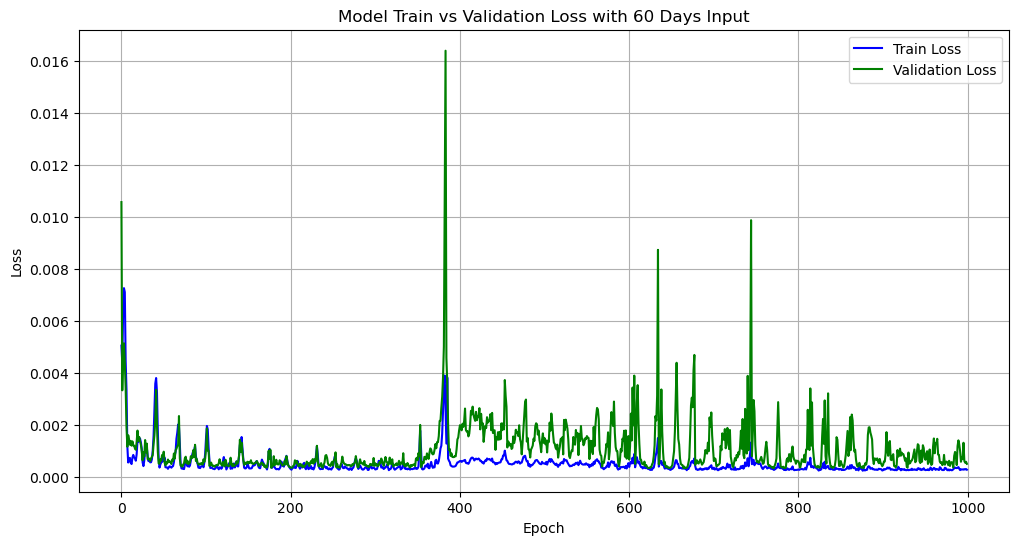

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted stock price for 2024-12-31 (using last 60 days): $426.67


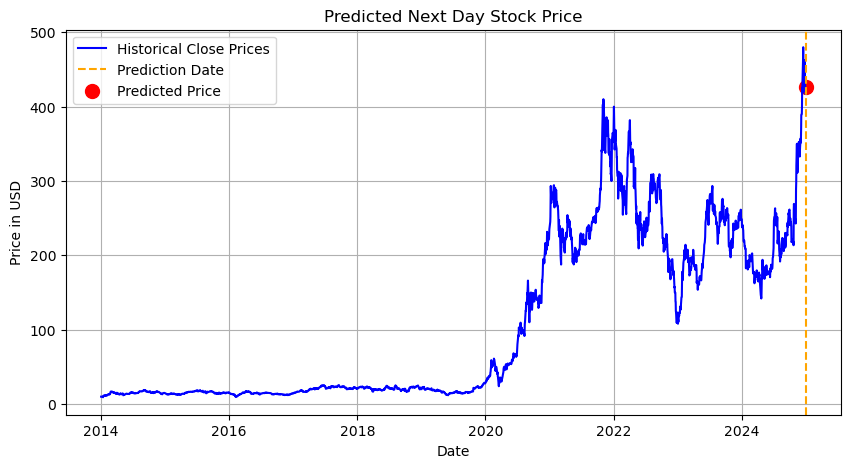

Epoch 1/1000


c:\Users\ben\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 8.6681e-04 - val_loss: 0.0049
Epoch 2/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 3/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 4/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0068 - val_loss: 0.0047
Epoch 5/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0102 - val_loss: 0.0063
Epoch 6/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0151 - val_loss: 0.0045
Epoch 7/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0108 - val_loss: 0.0029
Epoch 8/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 9/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 10/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 4.3828e-04 - val_loss: 0.0019
Epoch 11/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 8.6144e-04 - val_loss: 0.0019
Epoch 12/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 3

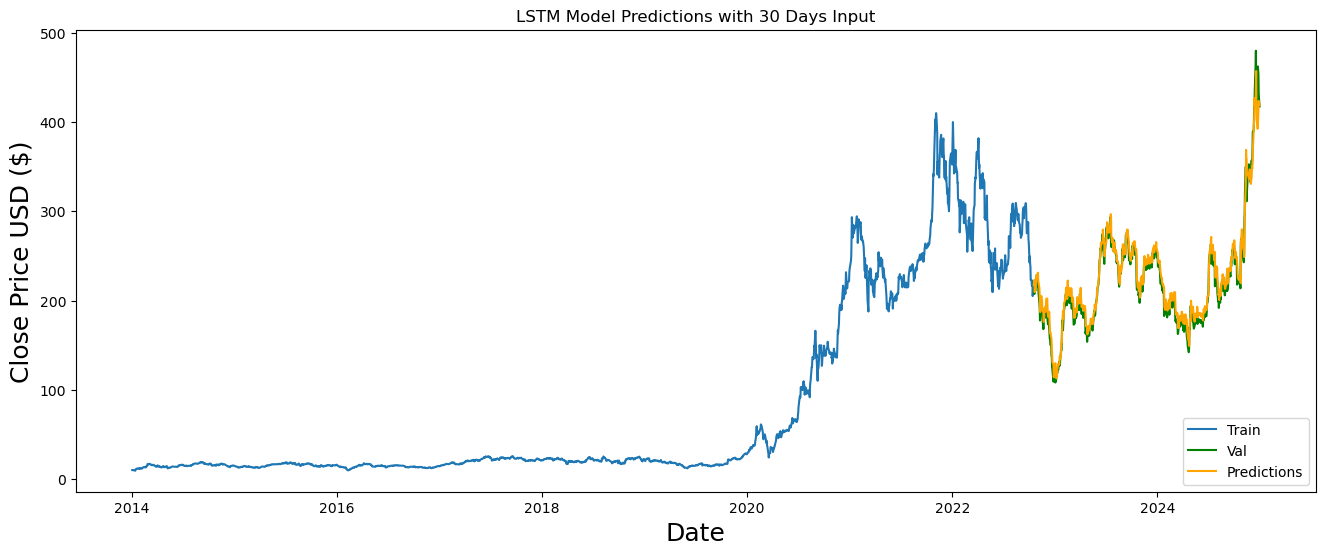

Performance metrics for input days 30:
R² Score: 0.9614
Mean Absolute Error (MAE): 8.5385
Mean Squared Error (MSE): 127.6787
Root Mean Squared Error (RMSE): 11.2995




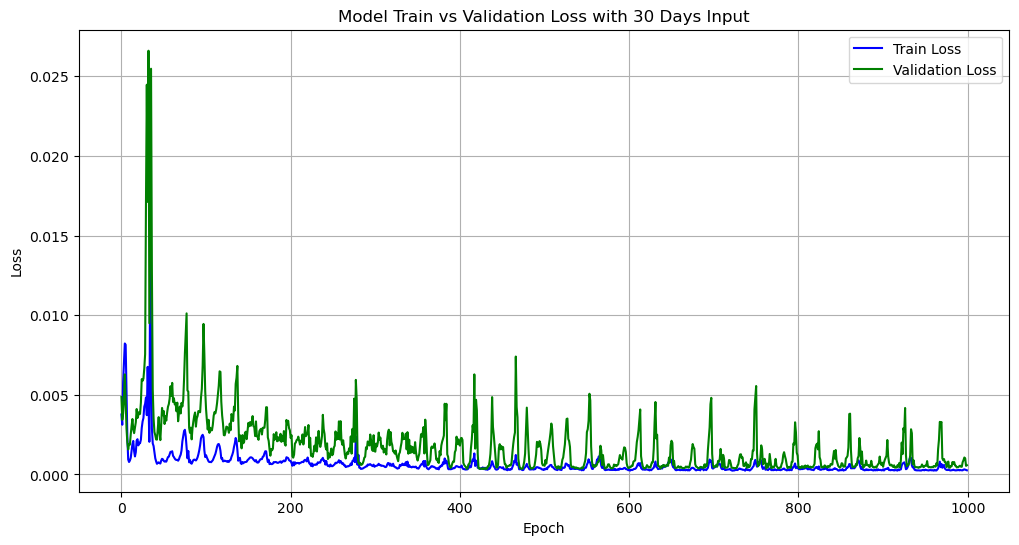

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted stock price for 2024-12-31 (using last 30 days): $412.77


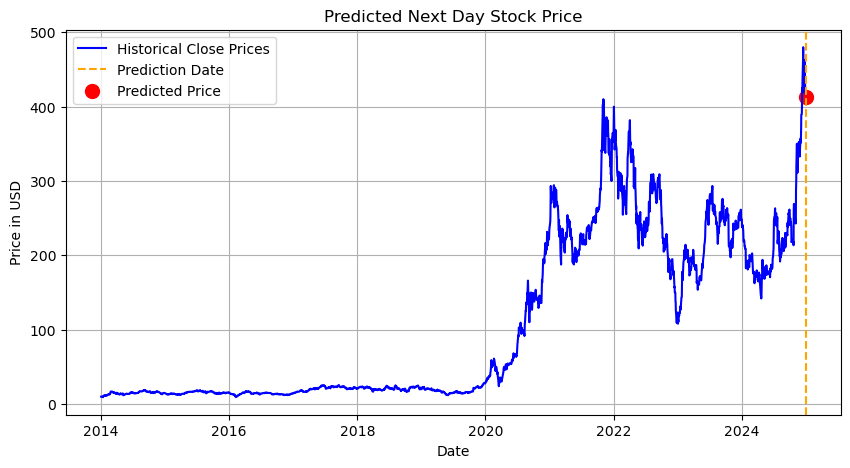

Epoch 1/1000


c:\Users\ben\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 6.7360e-04 - val_loss: 0.0071
Epoch 2/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 3/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 4/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0079 - val_loss: 0.0057
Epoch 5/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0113 - val_loss: 0.0037
Epoch 6/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0069 - val_loss: 0.0016
Epoch 7/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.7527e-04 - val_loss: 0.0030
Epoch 8/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.9171e-04 - val_loss: 0.0030
Epoch 9/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 10/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.8463e-04 - val_loss: 0.0022
Epoch 11/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.3345e-04 - val_loss: 0.0020
Epoch 12/1000
69/69 ━━━━━━━━━━━━━━

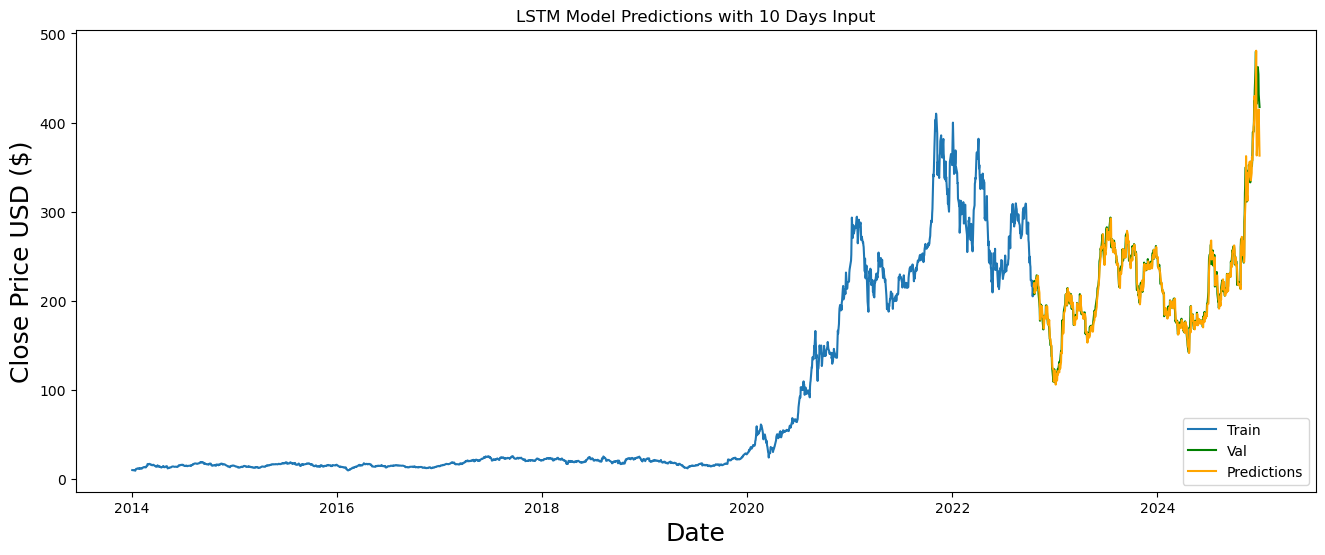

Performance metrics for input days 10:
R² Score: 0.9679
Mean Absolute Error (MAE): 6.5828
Mean Squared Error (MSE): 106.3648
Root Mean Squared Error (RMSE): 10.3133




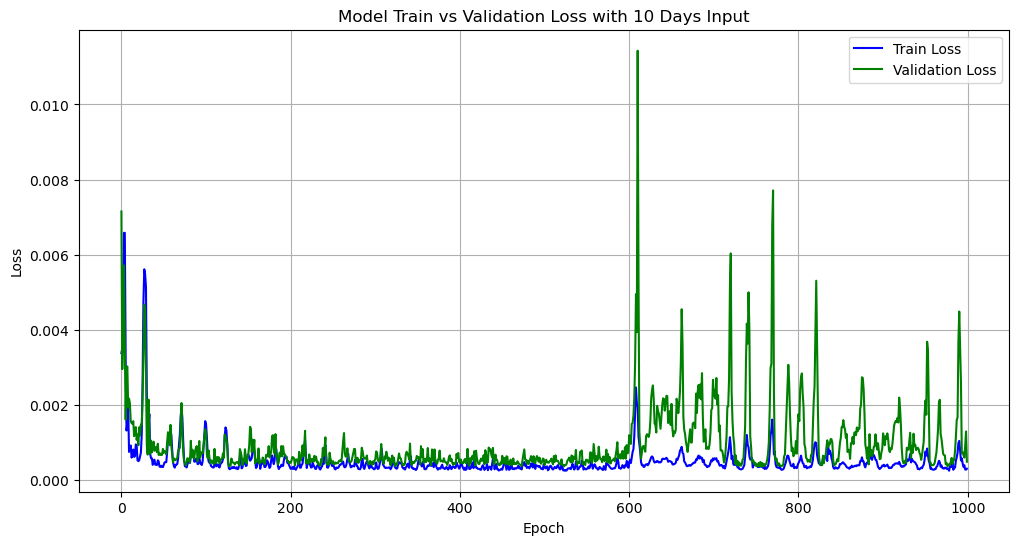

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted stock price for 2024-12-31 (using last 10 days): $290.08


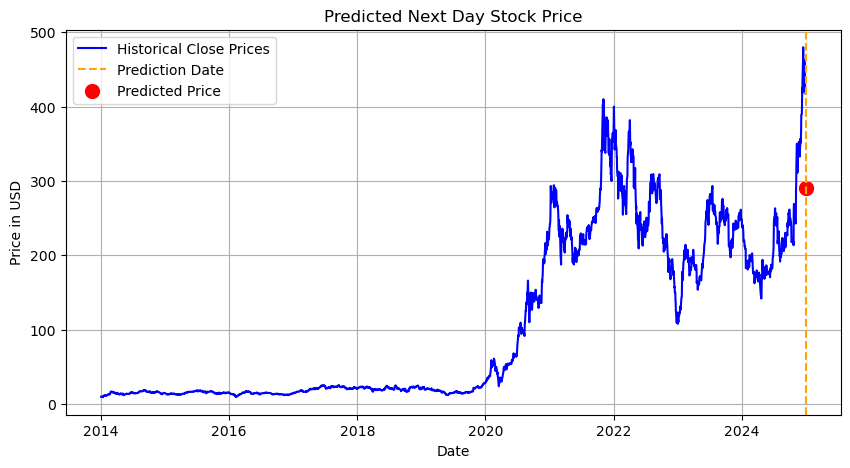

Epoch 1/1000


c:\Users\ben\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 8.4945e-04 - val_loss: 0.0110
Epoch 2/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0129 - val_loss: 0.0150
Epoch 3/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0212 - val_loss: 0.0105
Epoch 4/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0285 - val_loss: 0.0335
Epoch 5/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0316 - val_loss: 0.0499
Epoch 6/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0315 - val_loss: 0.0292
Epoch 7/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0145 - val_loss: 0.0011
Epoch 8/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.6458e-04 - val_loss: 0.0011
Epoch 9/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.2436e-04 - val_loss: 0.0013
Epoch 10/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 11/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 12/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

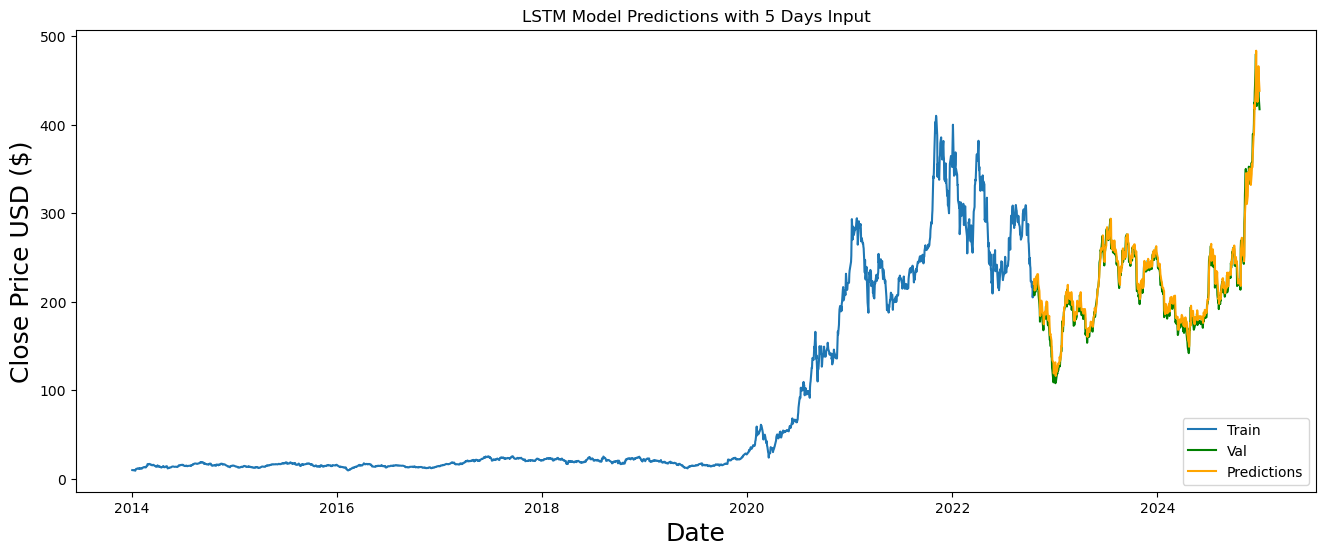

Performance metrics for input days 5:
R² Score: 0.9728
Mean Absolute Error (MAE): 7.1826
Mean Squared Error (MSE): 89.8919
Root Mean Squared Error (RMSE): 9.4811




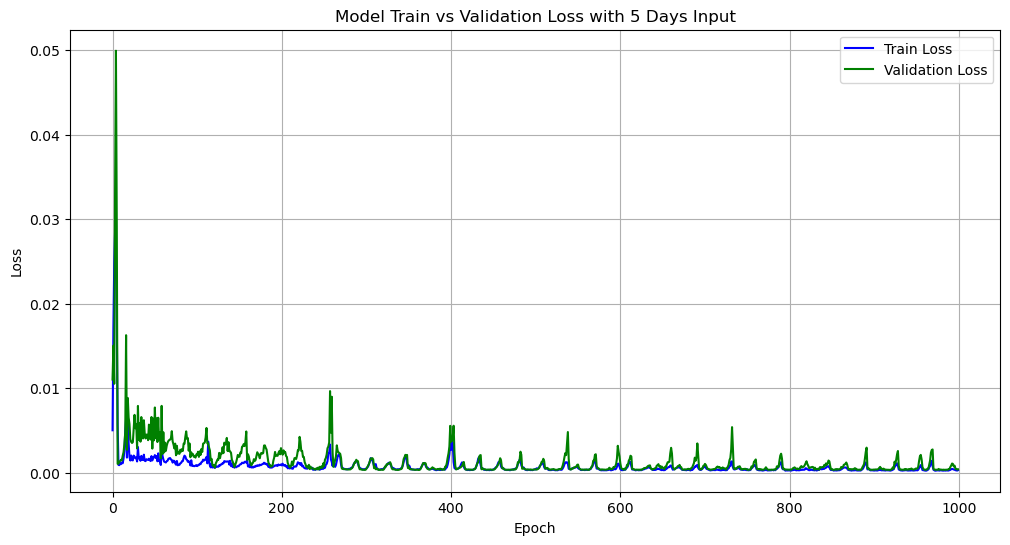

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted stock price for 2024-12-31 (using last 5 days): $422.43


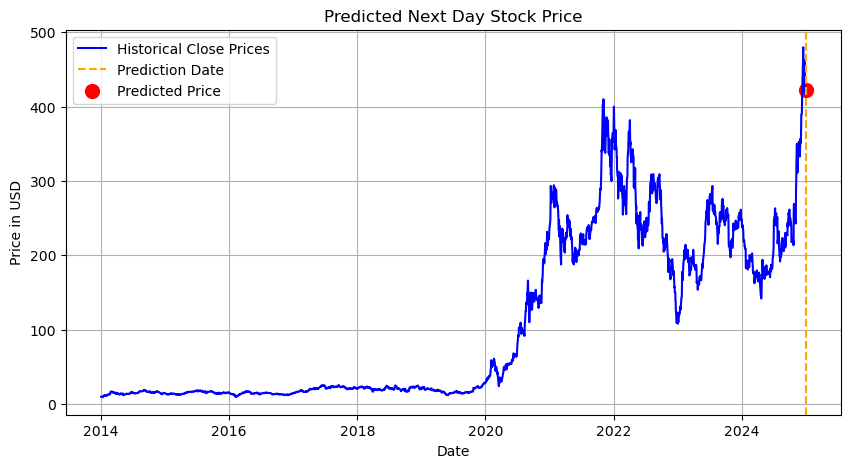

In [7]:
# Loop through different input lengths
for input_days in input_days_list:
    train_and_predict(input_days)